In [1]:
import warnings

# Ignore all warnings (not recommended unless you know what you are doing)
warnings.filterwarnings("ignore")
import os

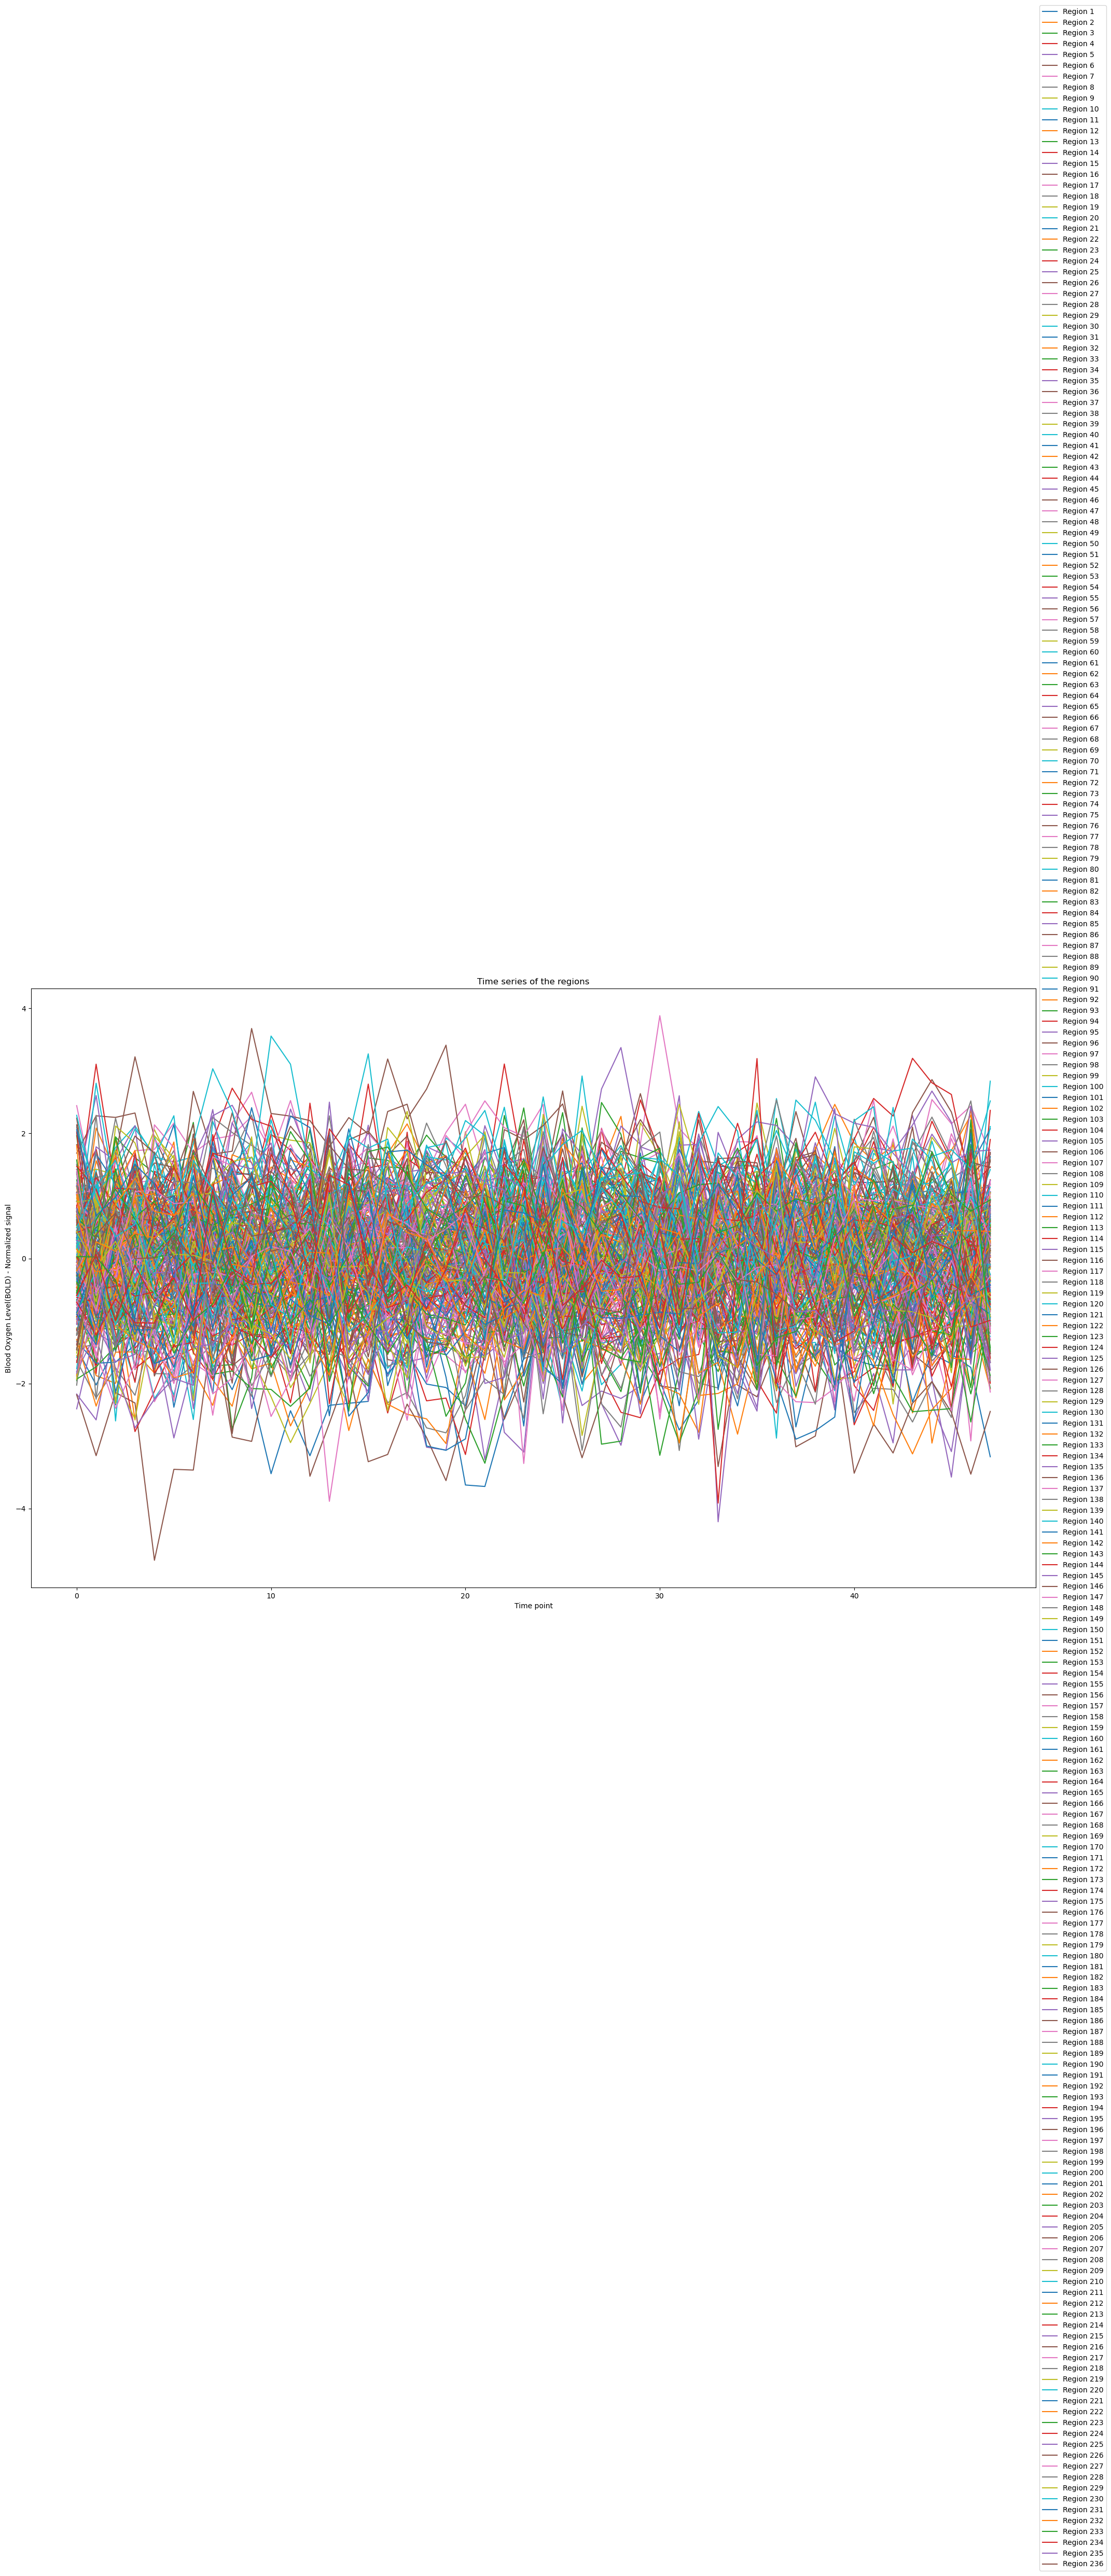

[[ 3.7443868   0.51856878 -0.90506136 ...  0.          0.
  -0.65541768]
 [ 0.51856878  5.89607796  0.         ...  0.          0.
   0.        ]
 [-0.90506136  0.          3.45909549 ...  0.         -0.52123355
   0.51980254]
 ...
 [ 0.          0.          0.         ...  7.10032461  0.
   0.        ]
 [ 0.          0.         -0.52123355 ...  0.          2.89726137
   0.        ]
 [-0.65541768  0.          0.51980254 ...  0.          0.
   5.0741098 ]]


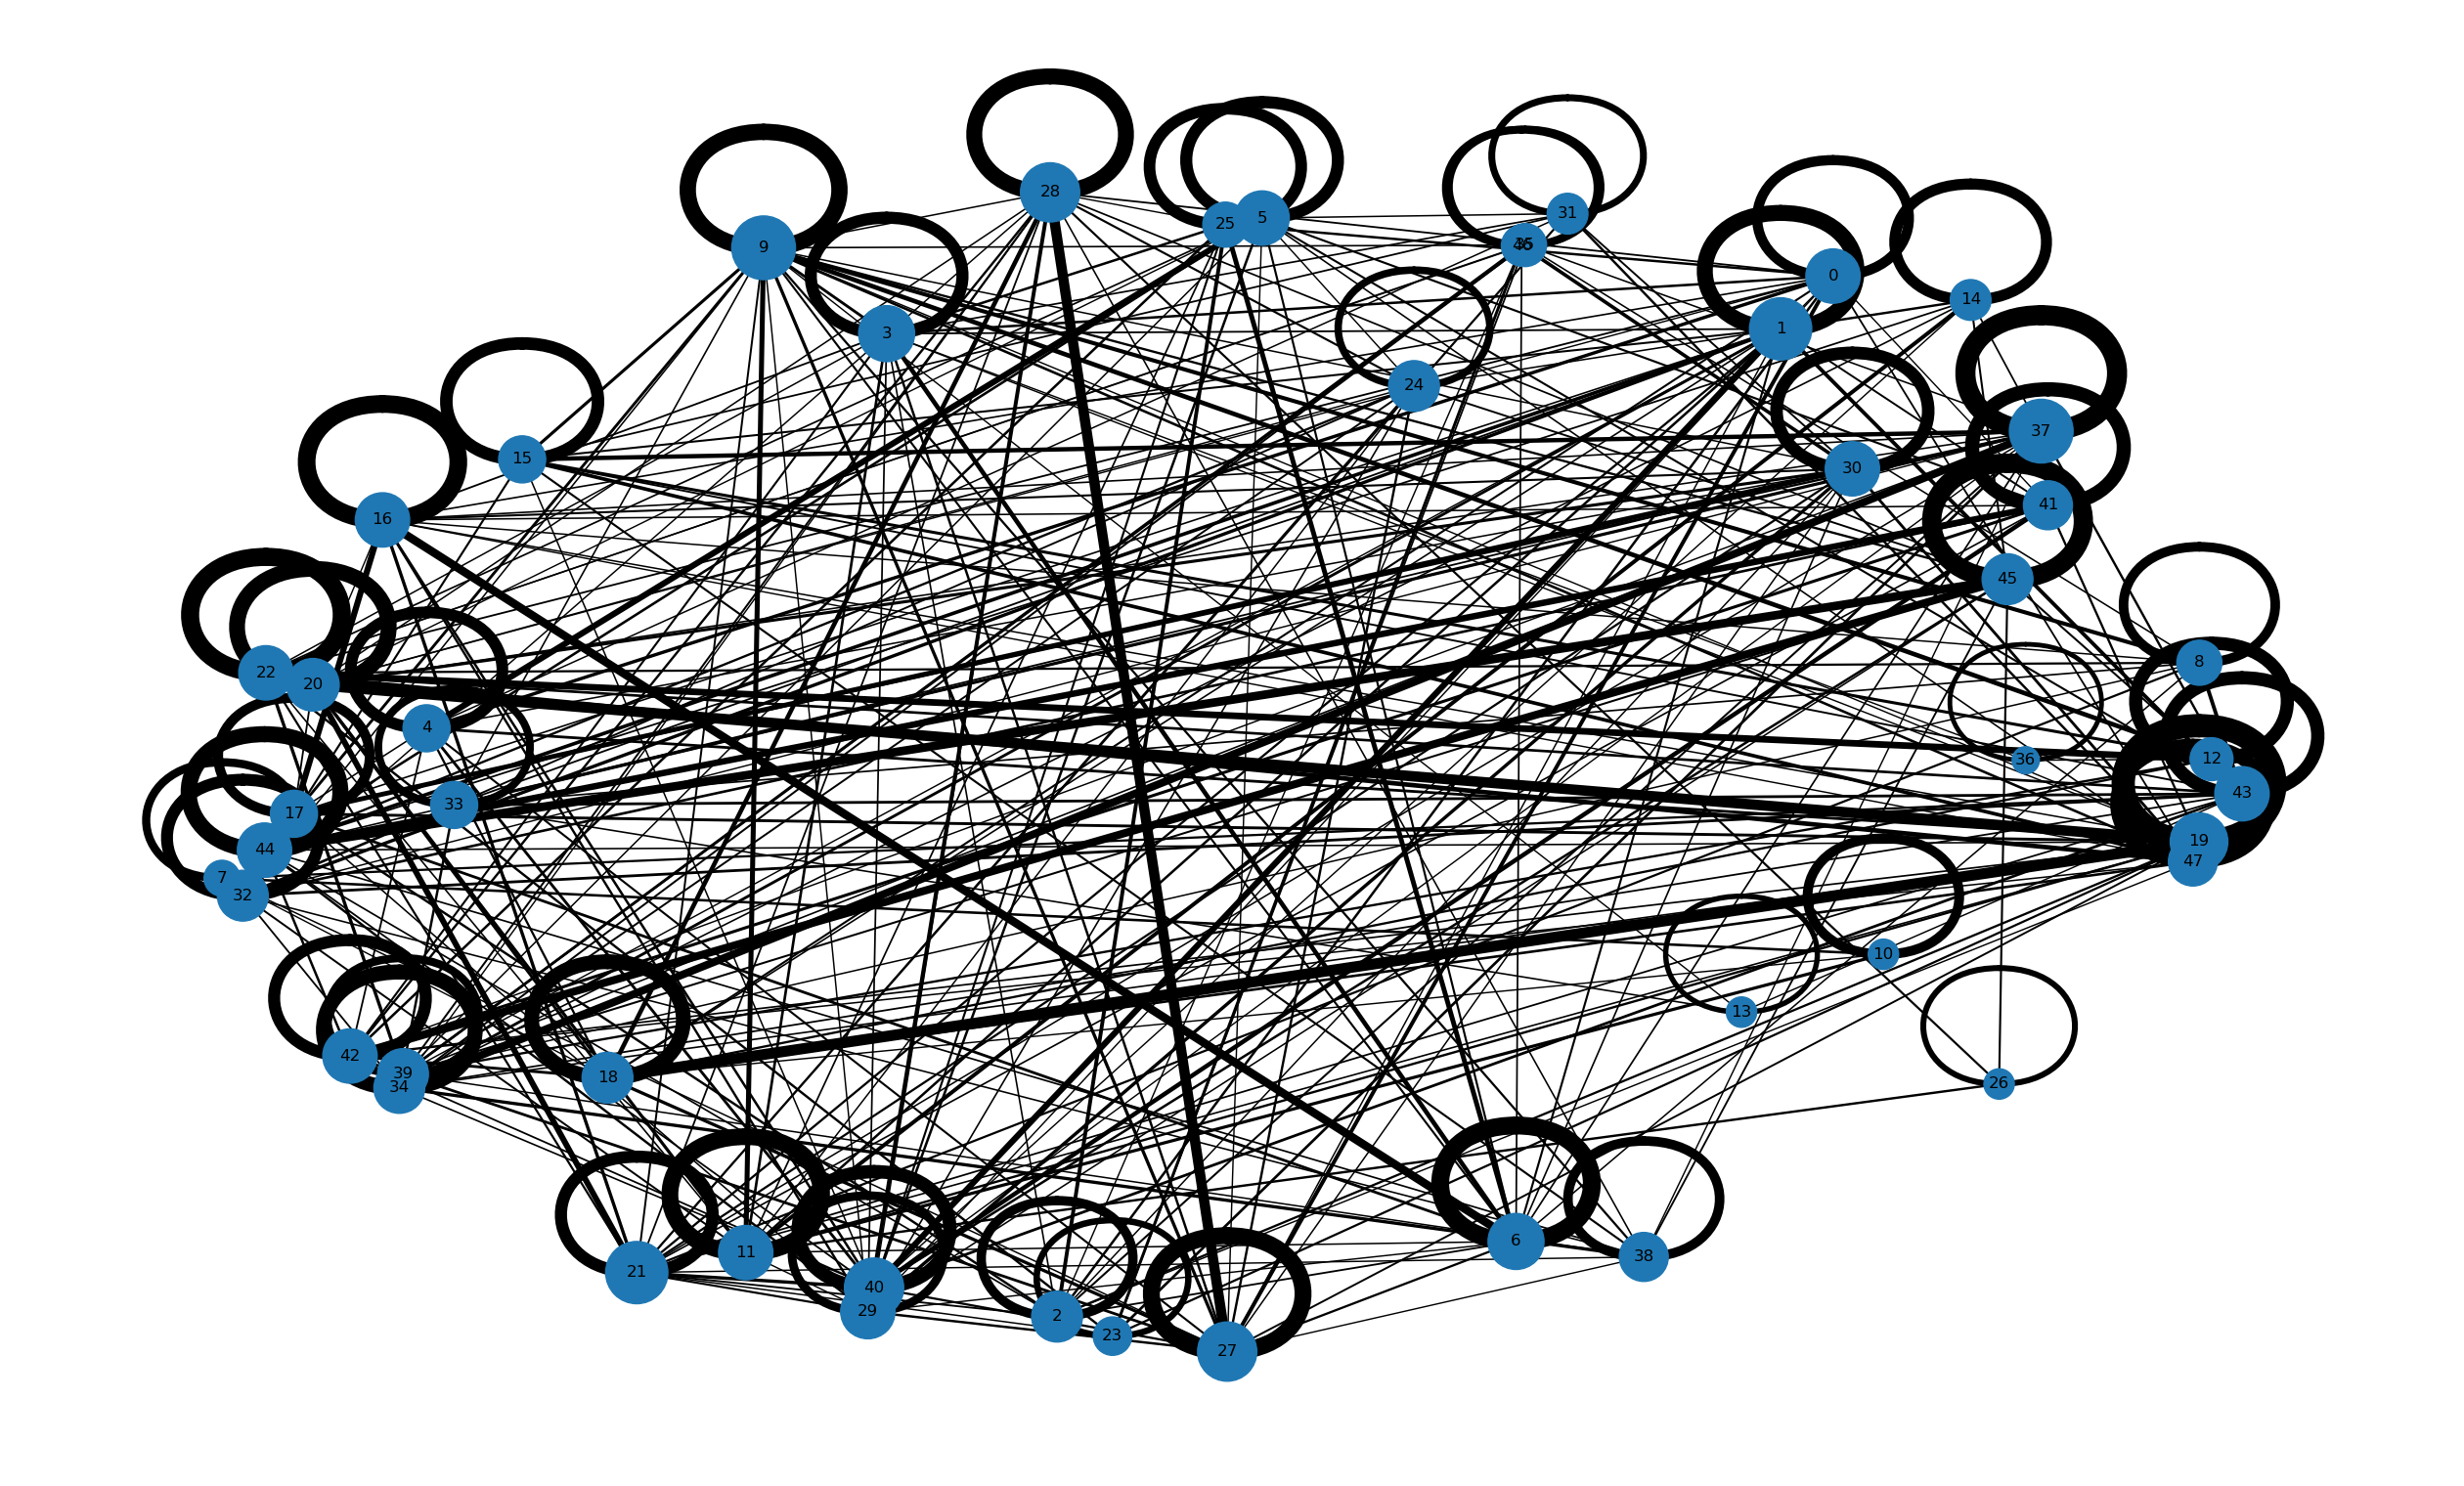

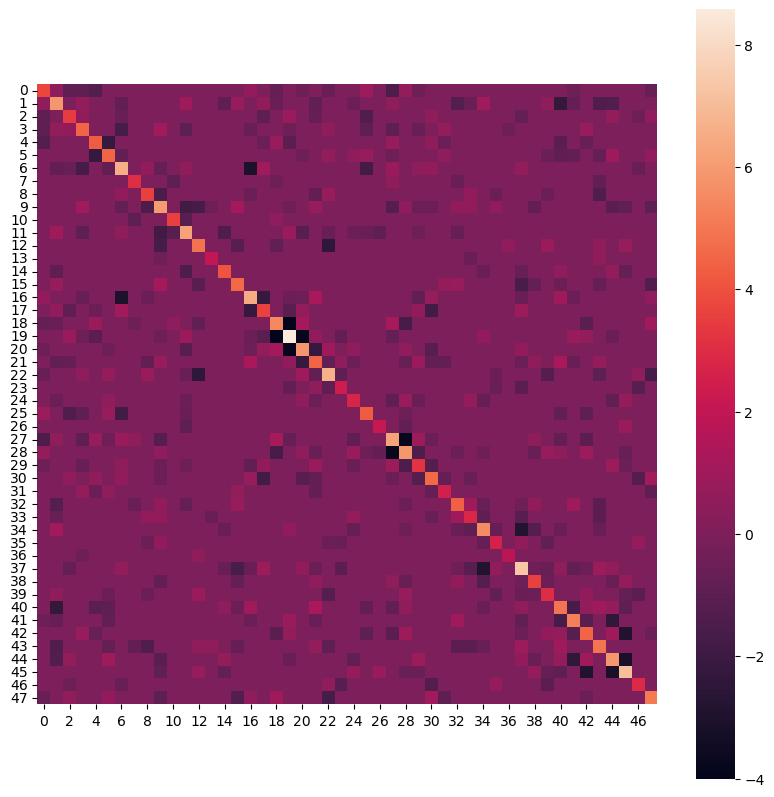

In [2]:
import pandas as pd
import numpy as np
import nibabel as nib
from nilearn import input_data, datasets
from nilearn.connectome import ConnectivityMeasure
import networkx as nx
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the CSV file
csv_file = pd.read_csv(r"/Users/vinoth/PycharmProjects/paper_implementation/Dataset/source/mri_images/ABIDE_pcp/Phenotypic_V1_0b_preprocessed1.csv")

# Replace labels 1 and 2 with 0 and 1
csv_file['DX_GROUP'].replace({1: 0, 2: 1}, inplace=True)

# Split data into training and test sets
train_df, test_df = train_test_split(csv_file, test_size=0.2, random_state=42)

# Load the Harvard-Oxford atlas
atlas = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
masker = input_data.NiftiLabelsMasker(labels_img=atlas.maps, standardize=True)

# MRI file directory
mri_dir = r"/Users/vinoth/PycharmProjects/paper_implementation/Dataset/source/mri_images/ABIDE_pcp/cpac/nofilt_noglobal/"
# Placeholder for Graph Neural Network Data
graph_data_list = []

for idx, row in enumerate(train_df.itertuples()):
    mri_filename = os.path.join(mri_dir, row.FILE_ID + "_func_preproc.nii.gz")
    try:
        mri_img = nib.load(mri_filename)

        # Calculate time series
        time_series = masker.fit_transform(mri_img)

        n_regions, n_time_points = time_series.shape
        number_of_entries = n_regions * n_time_points

        '''print("Number of regions:", n_regions)
        print("Number of time points:", n_time_points)
        print("Total number of entries:", number_of_entries'''

        if idx == 0:  # Only for the first iteration
            # Plot the time series for the regions
            plt.figure(figsize=(25, 15))  # Increase the size of the plot
            for i in range(min(n_regions, time_series.shape[0])):
                plt.plot(time_series[i, :], label=f'Region {i + 1}')

            plt.xlabel('Time point')
            plt.ylabel('Blood Oxygen Level(BOLD) - Normalized signal')
            plt.title('Time series of the regions')
            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Move the legend to the right of the plot
            plt.tight_layout()  # Adjust the layout to fit the plot and labels
            plt.show()

        # Create an adjacency matrix based on ROI correlations
        correlation_measure = ConnectivityMeasure(kind='covariance')
        correlation_matrix = correlation_measure.fit_transform([time_series])[0]

        # Threshold the correlation matrix (optional)
        threshold = 0.5  # Set the threshold value for the correlation
        correlation_matrix[abs(correlation_matrix) < threshold] = 0

        # Generate graph from correlation matrix
        G = nx.from_numpy_matrix(correlation_matrix)

        if idx == 0:  # Only for the first iteration
            print(correlation_matrix)

            # Step 6: Visualize the graph
            plt.figure(figsize=(25, 15))  # Increase the size of the plot
            pos = nx.spring_layout(G)  # Use spring layout
            node_sizes = [100 * np.abs(G.degree(n)) for n in G.nodes]  # Size nodes by their degree
            edge_widths = [2 * np.abs(G[u][v]['weight']) for u, v in G.edges]  # Width edges by their weight
            nx.draw(G, pos, node_size=node_sizes, width=edge_widths, with_labels=True)
            plt.show()

            # Plot the correlation matrix
            plt.figure(figsize=(10, 10))
            sns.heatmap(correlation_matrix, square=True)
            plt.show()

        # Generate edges and features for PyTorch Geometric
        edge_index = torch.tensor(list(G.edges), dtype=torch.long)
        x = torch.tensor(time_series, dtype=torch.float)
        y = torch.tensor([row.DX_GROUP], dtype=torch.float)

        # Create graph data for PyTorch Geometric
        data = Data(x=x, edge_index=edge_index.t().contiguous(), y=y)

        # Append data to list
        graph_data_list.append(data)
    except FileNotFoundError:
        pass


In [3]:
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import DataLoader
import torch.nn.functional as F

class Net(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        super(Net, self).__init__()
        self.conv1 = GCNConv(num_node_features, 16)
        self.conv2 = GCNConv(16, 32)
        self.fc = torch.nn.Linear(32, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        x = global_mean_pool(x, batch)  # Pooling

        x = self.fc(x)
        return F.log_softmax(x, dim=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Determine the number of features and classes
num_features = graph_data_list[0].num_node_features
num_classes = 2  # Autistic and non-autistic

# Instantiate the model and optimizer
model = Net(num_features, num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Create a data loader
loader = DataLoader(graph_data_list, batch_size=32, shuffle=True)

# Model Training
for epoch in range(100):
    total_loss = 0
    model.train()
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out, data.y.long())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch: {epoch+1}, Loss: {total_loss/len(loader)}')

# Model Evaluation
model.eval()
correct = 0
for data in loader:
    data = data.to(device)
    _, pred = model(data).max(dim=1)
    correct += int((pred == data.y.long()).sum())
print('Accuracy: {:.4f}'.format(correct/len(loader.dataset)))


Epoch: 1, Loss: 0.7069269039414146
Epoch: 2, Loss: 0.6869364299557426
Epoch: 3, Loss: 0.6858394579453901
Epoch: 4, Loss: 0.6878016943281348
Epoch: 5, Loss: 0.6681767349893396
Epoch: 6, Loss: 0.663607965816151
Epoch: 7, Loss: 0.6540239805525
Epoch: 8, Loss: 0.6220592368732799
Epoch: 9, Loss: 0.6420987546443939
Epoch: 10, Loss: 0.6014734655618668
Epoch: 11, Loss: 0.615338840267875
Epoch: 12, Loss: 0.6265274679118936
Epoch: 13, Loss: 0.5952925790439952
Epoch: 14, Loss: 0.603376030921936
Epoch: 15, Loss: 0.6146226958795027
Epoch: 16, Loss: 0.6059911156242545
Epoch: 17, Loss: 0.566759163683111
Epoch: 18, Loss: 0.5586039302023974
Epoch: 19, Loss: 0.6057424531741575
Epoch: 20, Loss: 0.5480798306790265
Epoch: 21, Loss: 0.5350263782522895
Epoch: 22, Loss: 0.5314324227246371
Epoch: 23, Loss: 0.5054670192978599
Epoch: 24, Loss: 0.5559854128144004
Epoch: 25, Loss: 0.5185004716569727
Epoch: 26, Loss: 0.6004943373528394
Epoch: 27, Loss: 0.5138851729306307
Epoch: 28, Loss: 0.487873220985586
Epoch: 29

Test Accuracy: 0.5968


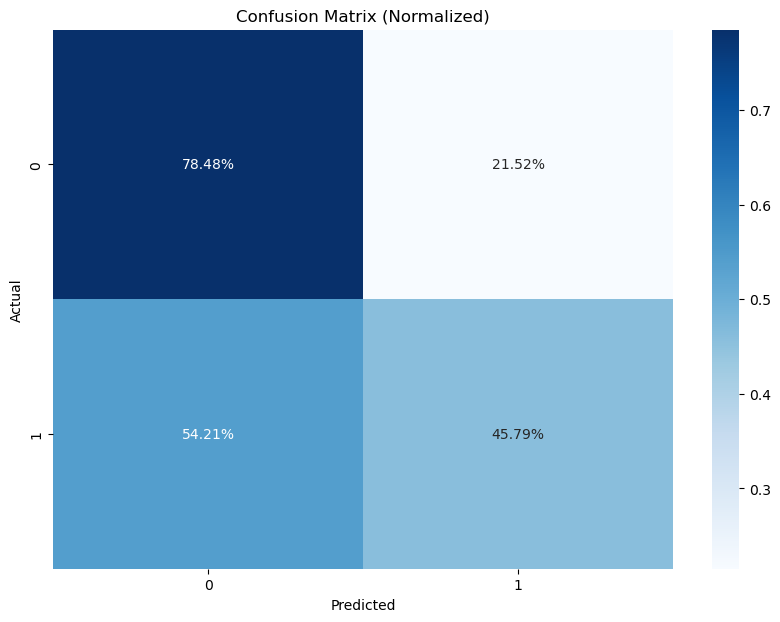

     Actual  Predicted
0       0.0          1
1       1.0          1
2       1.0          1
3       0.0          0
4       1.0          0
..      ...        ...
181     1.0          1
182     1.0          0
183     0.0          0
184     0.0          0
185     1.0          0

[186 rows x 2 columns]
              precision    recall  f1-score   support

Non-Autistic       0.52      0.78      0.62        79
    Autistic       0.74      0.46      0.57       107

    accuracy                           0.60       186
   macro avg       0.63      0.62      0.59       186
weighted avg       0.65      0.60      0.59       186



In [4]:
# Placeholder for Graph Neural Network Data for testing
graph_data_test_list = []

for idx, row in enumerate(test_df.itertuples()):
    mri_filename = os.path.join(mri_dir, row.FILE_ID + "_func_preproc.nii.gz")
    try:
        mri_img = nib.load(mri_filename)

        # Calculate time series
        time_series = masker.fit_transform(mri_img)

        # Create an adjacency matrix based on ROI correlations
        correlation_measure = ConnectivityMeasure(kind='covariance')
        correlation_matrix = correlation_measure.fit_transform([time_series])[0]

        # Threshold the correlation matrix (optional)
        threshold = 0.5  # Set the threshold value for the correlation
        correlation_matrix[abs(correlation_matrix) < threshold] = 0

        # Generate graph from correlation matrix
        G = nx.from_numpy_matrix(correlation_matrix)

        # Generate edges and features for PyTorch Geometric
        edge_index = torch.tensor(list(G.edges), dtype=torch.long)
        x = torch.tensor(time_series, dtype=torch.float)
        y = torch.tensor([row.DX_GROUP], dtype=torch.float)

        # Create graph data for PyTorch Geometric
        data = Data(x=x, edge_index=edge_index.t().contiguous(), y=y)

        # Append data to list
        graph_data_test_list.append(data)
    except FileNotFoundError:
        pass

# Create a data loader for testing data
test_loader = DataLoader(graph_data_test_list, batch_size=32, shuffle=False)

# Testing
model.eval()
correct = 0
all_preds = []
all_labels = []

for data in test_loader:
    data = data.to(device)
    with torch.no_grad():
        output = model(data)
        _, pred = output.max(dim=1)
    all_preds.append(pred.cpu().numpy())
    all_labels.append(data.y.cpu().numpy())
    correct += int((pred == data.y.long()).sum())

accuracy = correct / len(test_loader.dataset)

print(f'Test Accuracy: {accuracy:.4f}')

# Flatten the list of predictions and labels
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

'''cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()'''

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, cmap='Blues', fmt=".2%")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Normalized)')
plt.show()

# Print actual vs predicted
actual_vs_predicted = pd.DataFrame({'Actual': all_labels, 'Predicted': all_preds})
print(actual_vs_predicted)


# Classification report
from sklearn.metrics import classification_report

print(classification_report(all_labels, all_preds, target_names=['Non-Autistic', 'Autistic']))


GCN - Epoch: 1, Loss: 0.6986366483298215
GCN - Epoch: 2, Loss: 0.689697956497019
GCN - Epoch: 3, Loss: 0.6883008209141818
GCN - Epoch: 4, Loss: 0.6831022500991821
GCN - Epoch: 5, Loss: 0.6649160872806202
GCN - Epoch: 6, Loss: 0.6850509779019789
GCN - Epoch: 7, Loss: 0.6652749614282087
GCN - Epoch: 8, Loss: 0.6493765630505302
GCN - Epoch: 9, Loss: 0.6327805437824943
GCN - Epoch: 10, Loss: 0.622254880991849
GCN - Epoch: 11, Loss: 0.5979500196196816
GCN - Epoch: 12, Loss: 0.5814233137802645
GCN - Epoch: 13, Loss: 0.5814260569485751
GCN - Epoch: 14, Loss: 0.593348354101181
GCN - Epoch: 15, Loss: 0.5872071913697503
GCN - Epoch: 16, Loss: 0.5837550989606164
GCN - Epoch: 17, Loss: 0.5392368070103906
GCN - Epoch: 18, Loss: 0.5440956787629561
GCN - Epoch: 19, Loss: 0.5444811230356043
GCN - Epoch: 20, Loss: 0.5539620396765795
GCN - Epoch: 21, Loss: 0.5039454346353357
GCN - Epoch: 22, Loss: 0.5585078122940931
GCN - Epoch: 23, Loss: 0.5105968862771988
GCN - Epoch: 24, Loss: 0.49673129482702777
GCN

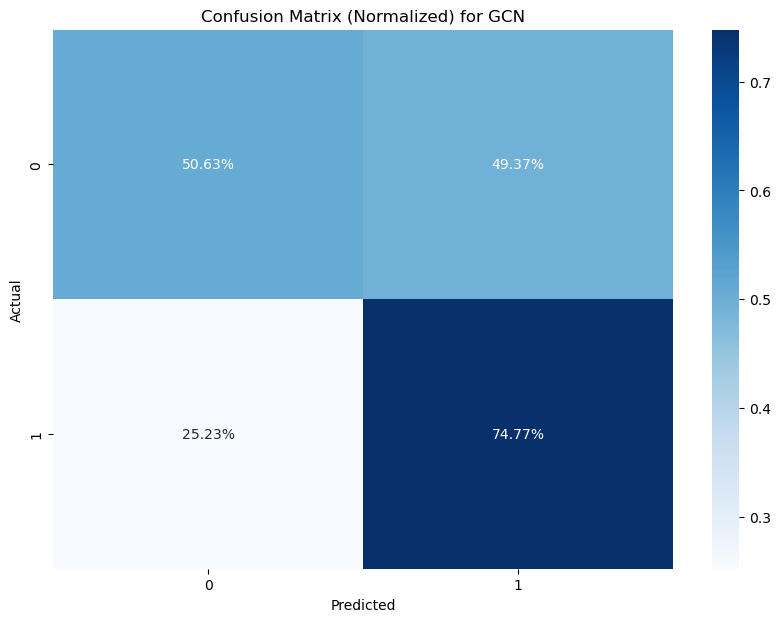

GAT - Epoch: 1, Loss: 0.6972044489600442
GAT - Epoch: 2, Loss: 0.6898164044726979
GAT - Epoch: 3, Loss: 0.6796689331531525
GAT - Epoch: 4, Loss: 0.6780265217477625
GAT - Epoch: 5, Loss: 0.6580528291788968
GAT - Epoch: 6, Loss: 0.6629305427724664
GAT - Epoch: 7, Loss: 0.6331339343027635
GAT - Epoch: 8, Loss: 0.6026403741403059
GAT - Epoch: 9, Loss: 0.6023528928106482
GAT - Epoch: 10, Loss: 0.5822733451019634
GAT - Epoch: 11, Loss: 0.5947719392451373
GAT - Epoch: 12, Loss: 0.5631078833883459
GAT - Epoch: 13, Loss: 0.5415242084048011
GAT - Epoch: 14, Loss: 0.5485625456679951
GAT - Epoch: 15, Loss: 0.5787337584929033
GAT - Epoch: 16, Loss: 0.5456968247890472
GAT - Epoch: 17, Loss: 0.5529547116973184
GAT - Epoch: 18, Loss: 0.5285873954946344
GAT - Epoch: 19, Loss: 0.5061595074155114
GAT - Epoch: 20, Loss: 0.49282240054824134
GAT - Epoch: 21, Loss: 0.5008081326430495
GAT - Epoch: 22, Loss: 0.49014969847419043
GAT - Epoch: 23, Loss: 0.5253020375967026
GAT - Epoch: 24, Loss: 0.4669816724278710

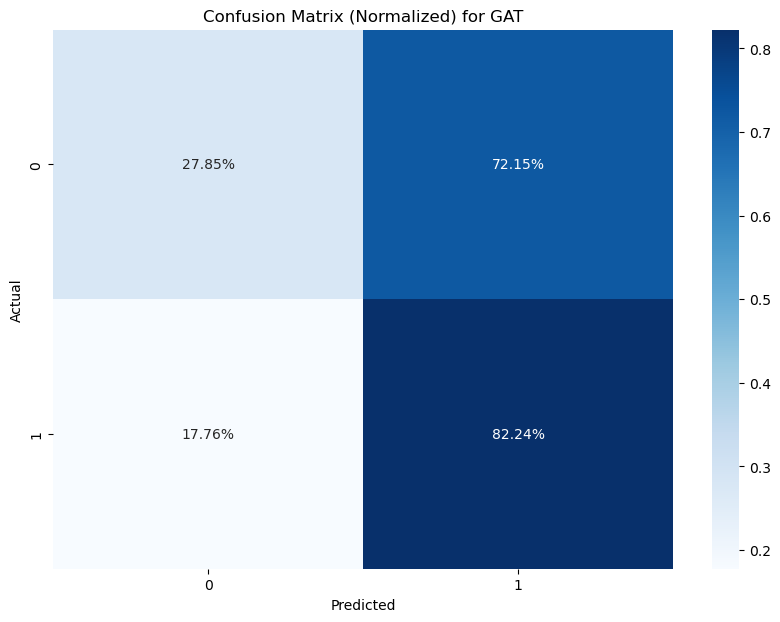

SAGE - Epoch: 1, Loss: 0.6951719305732034
SAGE - Epoch: 2, Loss: 0.6937895823608745
SAGE - Epoch: 3, Loss: 0.6865260844880884
SAGE - Epoch: 4, Loss: 0.6818782768466256
SAGE - Epoch: 5, Loss: 0.6616281569004059
SAGE - Epoch: 6, Loss: 0.6709180040792986
SAGE - Epoch: 7, Loss: 0.6276395402171395
SAGE - Epoch: 8, Loss: 0.6206848296252164
SAGE - Epoch: 9, Loss: 0.5954311652617021
SAGE - Epoch: 10, Loss: 0.5692931779406287
SAGE - Epoch: 11, Loss: 0.5674396739764647
SAGE - Epoch: 12, Loss: 0.6136956377462908
SAGE - Epoch: 13, Loss: 0.5728007920763709
SAGE - Epoch: 14, Loss: 0.556074620647864
SAGE - Epoch: 15, Loss: 0.5279089957475662
SAGE - Epoch: 16, Loss: 0.5443692166696895
SAGE - Epoch: 17, Loss: 0.5069904747334394
SAGE - Epoch: 18, Loss: 0.5016745179891586
SAGE - Epoch: 19, Loss: 0.494337183508006
SAGE - Epoch: 20, Loss: 0.47165785188024695
SAGE - Epoch: 21, Loss: 0.4715789014642889
SAGE - Epoch: 22, Loss: 0.4928850680589676
SAGE - Epoch: 23, Loss: 0.48842381753704767
SAGE - Epoch: 24, Lo

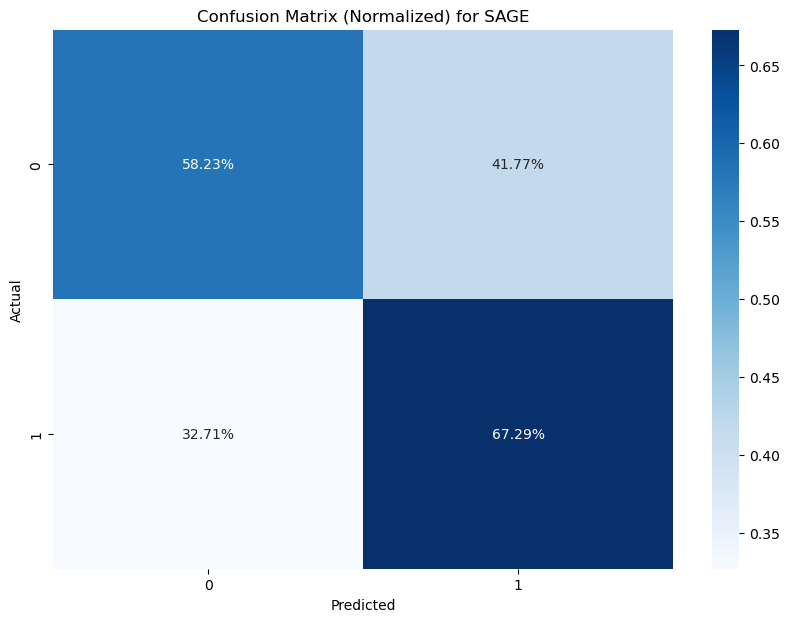

GIN - Epoch: 1, Loss: 0.7008945481343702
GIN - Epoch: 2, Loss: 0.6932908404957164
GIN - Epoch: 3, Loss: 0.6909349912946875
GIN - Epoch: 4, Loss: 0.6934226588769392
GIN - Epoch: 5, Loss: 0.6917319351976569
GIN - Epoch: 6, Loss: 0.685425422408364
GIN - Epoch: 7, Loss: 0.6791841306469657
GIN - Epoch: 8, Loss: 0.6792161329226061
GIN - Epoch: 9, Loss: 0.6764416640455072
GIN - Epoch: 10, Loss: 0.6643830077214674
GIN - Epoch: 11, Loss: 0.6450265659527346
GIN - Epoch: 12, Loss: 0.6459767493334684
GIN - Epoch: 13, Loss: 0.6154694570736452
GIN - Epoch: 14, Loss: 0.639843611554666
GIN - Epoch: 15, Loss: 0.6102211299267682
GIN - Epoch: 16, Loss: 0.5805842497132041
GIN - Epoch: 17, Loss: 0.5763150710951198
GIN - Epoch: 18, Loss: 0.5656048303300684
GIN - Epoch: 19, Loss: 0.5357964120127938
GIN - Epoch: 20, Loss: 0.4916796494613994
GIN - Epoch: 21, Loss: 0.48105270618742163
GIN - Epoch: 22, Loss: 0.5213071378794584
GIN - Epoch: 23, Loss: 0.4555945775725625
GIN - Epoch: 24, Loss: 0.41032863611524756
G

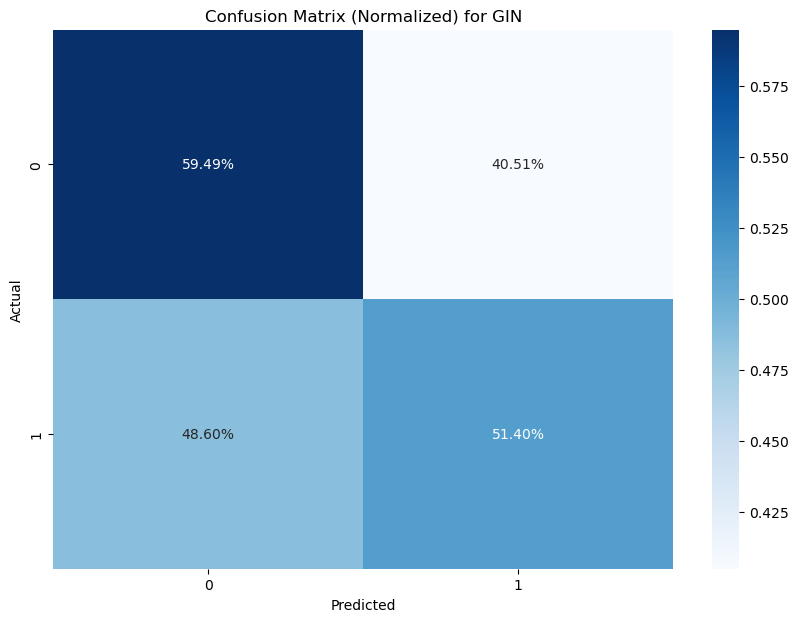

  Model  Train_Accuracy  Test_Accuracy  Precision    Recall  F1-Score
0   GCN        0.919708       0.645161   0.634642  0.626996  0.627955
1   GAT        0.832117       0.591398   0.571741  0.550455  0.532540
2  SAGE        0.981022       0.634409   0.626808  0.627588  0.627123
3   GIN        0.992701       0.548387   0.553466  0.554478  0.547550


In [5]:
from torch_geometric.nn import GCNConv, GATConv, SAGEConv, GINConv, global_mean_pool
from torch_geometric.data import DataLoader
import pandas as pd

class Net(torch.nn.Module):
    def __init__(self, conv_layer, num_node_features, num_classes):
        super(Net, self).__init__()
        if conv_layer == GINConv:
            nn1 = torch.nn.Sequential(torch.nn.Linear(num_node_features, 16), torch.nn.ReLU(), torch.nn.Linear(16, 16))
            self.conv1 = conv_layer(nn1)
            nn2 = torch.nn.Sequential(torch.nn.Linear(16, 32), torch.nn.ReLU(), torch.nn.Linear(32, 32))
            self.conv2 = conv_layer(nn2)
        else:
            self.conv1 = conv_layer(num_node_features, 16)
            self.conv2 = conv_layer(16, 32)
        self.fc = torch.nn.Linear(32, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        x = global_mean_pool(x, batch)  # Pooling

        x = self.fc(x)
        return F.log_softmax(x, dim=1)

    
# Define models and their names
models = [GCNConv, GATConv, SAGEConv, GINConv]
model_names = ['GCN', 'GAT', 'SAGE', 'GIN']

# Initialize an empty DataFrame to store the results
results = pd.DataFrame(columns=["Model", "Train_Accuracy", "Test_Accuracy"])


from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

results = pd.DataFrame(columns=["Model", "Train_Accuracy", "Test_Accuracy", "Precision", "Recall", "F1-Score"])

# Model Training and Evaluation for each Convolution Layer
for model_name, model_class in zip(model_names, models):
    model = Net(model_class, num_features, num_classes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    # Training
    for epoch in range(100):
        total_loss = 0
        model.train()
        for data in loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data)
            loss = F.nll_loss(out, data.y.long())
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'{model_name} - Epoch: {epoch+1}, Loss: {total_loss/len(loader)}')

    # Evaluation on Training Data
    model.eval()
    correct = 0
    for data in loader:
        data = data.to(device)
        _, pred = model(data).max(dim=1)
        correct += int((pred == data.y.long()).sum())
    train_accuracy = correct / len(loader.dataset)
    print(f'{model_name} Train Accuracy: {train_accuracy:.4f}')

    # Evaluation on Test Data
    correct = 0
    all_preds = []
    all_labels = []
    for data in test_loader:
        data = data.to(device)
        with torch.no_grad():
            output = model(data)
            _, pred = output.max(dim=1)
        all_preds.append(pred.cpu().numpy())
        all_labels.append(data.y.cpu().numpy())
        correct += int((pred == data.y.long()).sum())
    test_accuracy = correct / len(test_loader.dataset)
    print(f'{model_name} Test Accuracy: {test_accuracy:.4f}')

    # Flatten the list of predictions and labels
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt=".2%")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix (Normalized) for {model_name}')
    plt.show()

    # Classification report
    report = classification_report(all_labels, all_preds, target_names=['Non-Autistic', 'Autistic'], output_dict=True)

    # Append the accuracy to the results DataFrame
    results = results.append({
        "Model": model_name,
        "Train_Accuracy": train_accuracy,
        "Test_Accuracy": test_accuracy,
        "Precision": report['macro avg']['precision'],
        "Recall": report['macro avg']['recall'],
        "F1-Score": report['macro avg']['f1-score'],
    }, ignore_index=True)

print(results)

